# Lezione 07

## Dario Pullia

### Esercizio 07.2

Spiegazioni varie

/home/dario/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


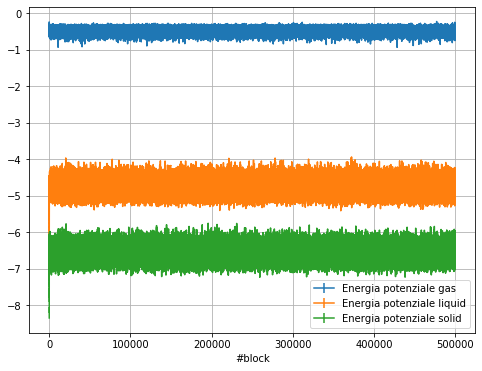

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np

npart=108


def DataBlocking(Epot, L):
    M=x[-1]
    N=int(M/L)
    E=0
    E2=0
    res=[]
    resErr=[]

    for i in range(N):
        Sum=0
        for j in range (L):
            Sum+=Epot[j+i*L]
        E=(Sum/L + E*i)/(i+1)
        E2=((Sum/L)**2 +E2*i)/(i+1)

    return error_prog(E, E2, N)


def error_prog( AV,  AV2,  n):
    if (n==0):
        return 0
    else:
        return math.sqrt((AV2-AV*AV)/n)


def AutoC(t, vec):
    appo1=0
    appo2=0
    appo3=0
    appo4=0
    appo5=0
    tmax=0
    tmax=vec.size
    for i in range(tmax-t):
        appo1+=vec[i]*vec[i+t]
        appo2+=vec[i]
        appo3+=vec[i+t]
    for i in range(tmax):
        appo4+=vec[i]*vec[i]
        appo5+=vec[i]
        
    return (appo1/(tmax-t) - appo2*appo3/((tmax-t)*(tmax-t)))/((appo4/tmax)-(appo5/tmax)**2)    






fig=plt.figure(figsize=(8, 6))

for s in ['gas','liquid','solid']:
    x, Epot, EpotAVG, EpotErr= np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(0,1,2,3), delimiter=' ', unpack='true')

    plt.errorbar(x,Epot, yerr=EpotErr, marker="", label="Energia potenziale "+s)



plt.xlabel('#block')
plt.ylabel('')
plt.grid(True)
plt.legend()
plt.show()

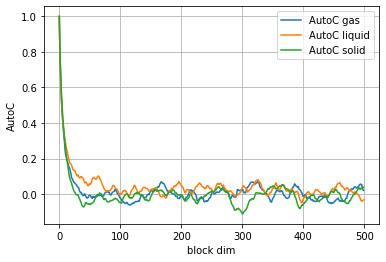

In [4]:

for s in ['gas','liquid','solid']:
    Epot = np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')

    ACor=[]

    for i in range(500):

        ACor.append(AutoC(i, Epot[:5000])) #Autocorrelare oltre i primi 5000 appesantisce inutilmente
        
    plt.plot(np.arange(500),ACor, label='AutoC '+s)

plt.xlabel('block dim')
plt.ylabel('AutoC')
plt.grid(True)
plt.legend()
plt.show()

Ora farò data blocking sui dati dei blocchi da una misura per blocco

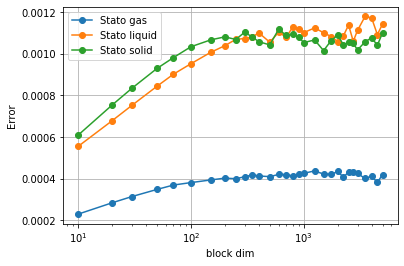

In [5]:
L=[10,20,30,50,70,100,150, 200,250, 300,350, 400,500, 600,700,800,900,1000,1250,1500,1750,2000,2250,2500,2750,3000,3500,4000,4500,5000]

for s in ['gas','liquid','solid']:
    Epot= np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')

    Errors=[]
    for i in L:
        Errors.append(DataBlocking(Epot, i))


    plt.plot(L,Errors, marker="o",label='Stato '+s)
    
    
plt.xlabel('block dim')
plt.ylabel('Error')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()    

### Esercizio 07.3
Ho dato nomi brutti alle variabili dentro

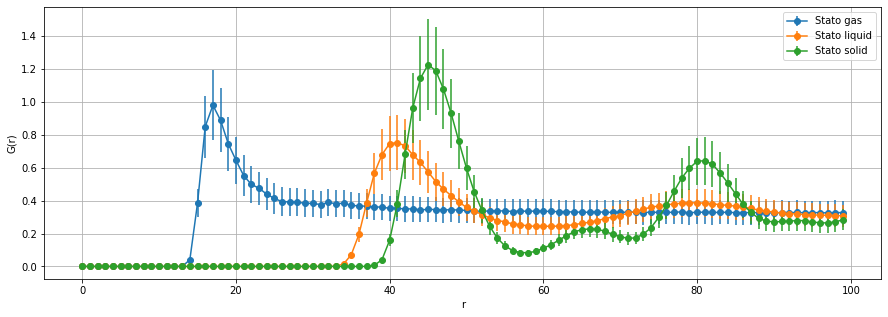

In [19]:

fig=plt.figure(figsize=(15, 5))

for s in ['gas','liquid','solid']:
    row= np.loadtxt("data03/"+s+"/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
    Gr=[]
    GrError=[]
    row=np.delete(row, 0)
    for i,elem in enumerate(row):
        if i%3==0:
            Gr.append(elem)
        if i%3==2:
            GrError.append(elem)
            
    plt.errorbar(np.arange(100),Gr, yerr=GrError, marker="o",label='Stato '+s)


plt.xlabel('r')
plt.ylabel('G(r)')
plt.grid(True)
plt.legend()
plt.show()    

### Esercizio 07.4

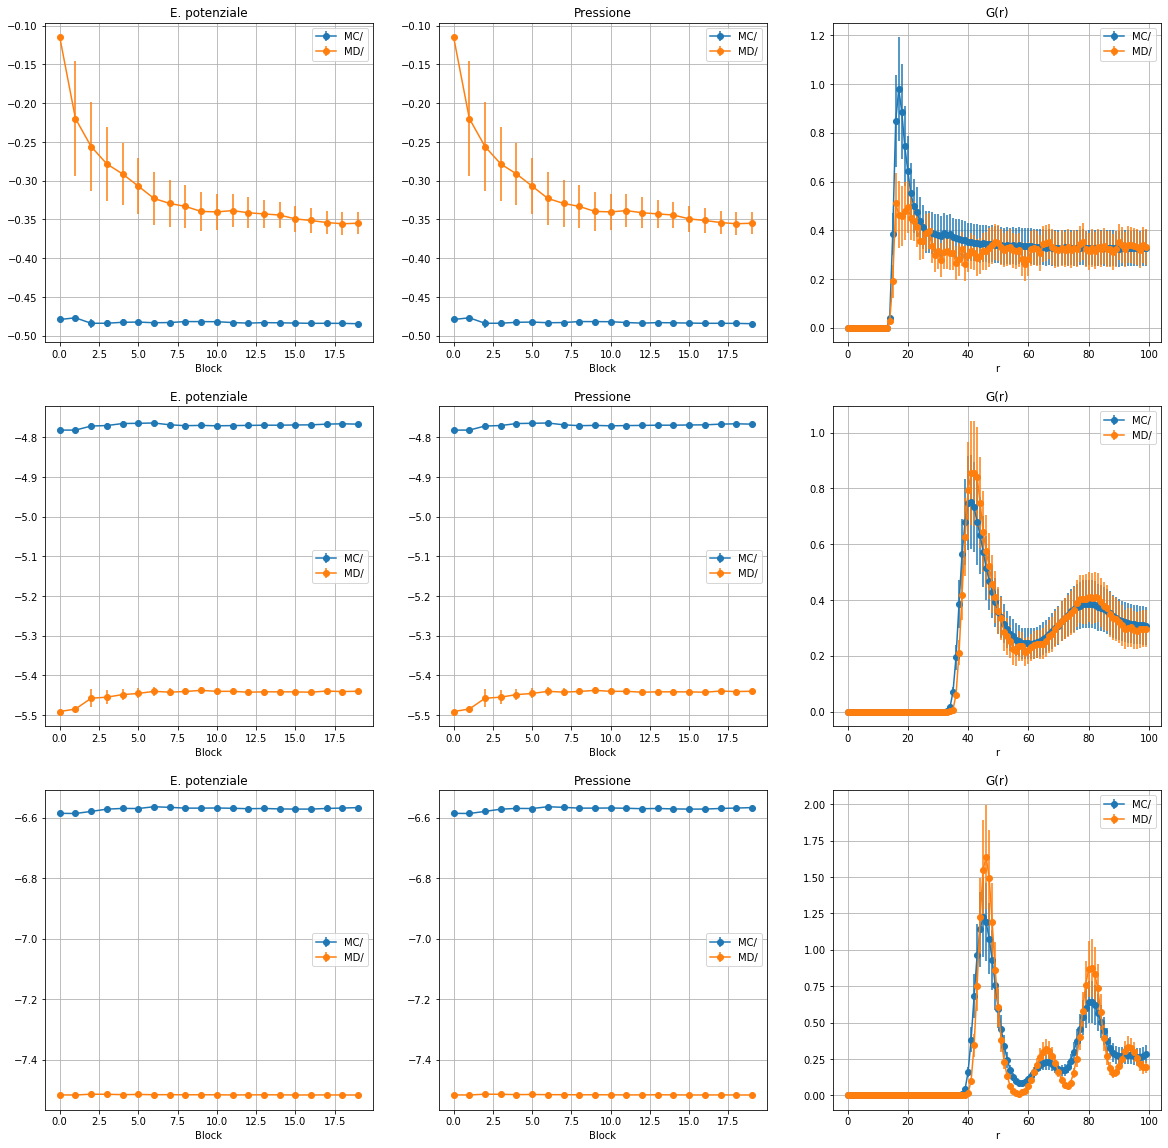

In [22]:

fig, ax= plt.subplots(3, 3,figsize=(20, 20))

for k, s in enumerate(['gas','liquid','solid']):
    for j, mode in enumerate(['MC/','MD/']):
        Epot, Epot_err= np.loadtxt("data04/"+mode+s+"/output_epot.dat", usecols=(2,3), delimiter=' ', unpack='true')
        Pres, Pres_err= np.loadtxt("data04/"+mode+s+"/output_epot.dat", usecols=(2,3), delimiter=' ', unpack='true')
        row= np.loadtxt("data04/"+mode+s+"/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
        Gr=[]
        GrError=[]
        row=np.delete(row, 0)
        for i,elem in enumerate(row):
            if i%3==0:
                Gr.append(elem)
            if i%3==2:
                GrError.append(elem)
        ax[k][0].errorbar(np.arange(20),Epot, yerr=Epot_err, marker="o",label=mode)
        ax[k][1].errorbar(np.arange(20),Pres, yerr=Pres_err, marker="o",label=mode)
        ax[k][2].errorbar(np.arange(100),Gr, yerr=GrError, marker="o",label=mode)
        
    ax[k][0].set_title('E. potenziale')
    ax[k][1].set_title('Pressione')
    ax[k][2].set_title('G(r)')

    ax[k][0].set_xlabel('Block')
    ax[k][1].set_xlabel('Block')
    ax[k][2].set_xlabel('r')

    ax[k][0].legend()
    ax[k][1].legend()
    ax[k][2].legend()
    
    ax[k][0].grid(True)
    ax[k][1].grid(True)
    ax[k][2].grid(True)
        
plt.show()